We can expand $\hat{H}_{dse}$ in terms of the dipole operator (with electronic and nuclear contributions) and dipole expectation values as follows:
\begin{align}
    \hat{H}_{dse} &= \frac{1}{2} \sum_{\xi, \xi'} \sum_{i \neq j} \lambda^{\xi} \lambda^{\xi'} \mu^{\xi}(x_i) \mu^{\xi'}(x_j) \\
    &+  \frac{1}{2} \sum_{\xi, \xi'} \sum_i \frac{1}{2} \lambda^{\xi} \lambda^{\xi'} Q^{\xi \xi'}(x_i) \\ 
   & + \left(\lambda \cdot \mu_{nuc} - \lambda \cdot \langle \mu \rangle \right) \sum_{\xi} \sum_i \lambda^{\xi} \mu^{\xi} (x_i)  \\
  &+ \frac{1}{2} \left( \lambda \cdot \mu_{nuc} \right)^2  - \left( \lambda \cdot \langle \mu \rangle \right) \left( \lambda \cdot \mu_{nuc} \right) + \frac{1}{2} \left( \lambda \cdot \langle \mu \rangle \right)^2
\end{align} 

In the above expansion of $\hat{H}_{dse}$ we have specifically indicated that the product of electronic dipole operators contains 2-electron contributions when $i \neq j$,
and 1-electron quadrupole contributions when $i = j$.  Furthermore, a
one-electron term arises that contains the electronic dipole operator
scaled by $\lambda \cdot \mu_{nuc}$.  In the QED-RHF procedure, the additional one-electron terms above will be added to $H_{core}$ and the additional two-electron terms above will be included in the density-matrix dependent terms in the Fock operator:
\begin{equation}
    F_{\mu \nu} + H_{\mu \nu} + G_{\mu \nu}
\end{equation}
where
\begin{align}
    H_{\mu \nu} &= h_{\mu \nu} + \frac{1}{2}\sum_{\xi, \xi'} \lambda^{\xi} \lambda^{\xi'} Q^{\xi \xi'}_{\mu \nu} \\
    &+ \left(\lambda \cdot \mu_{nuc} - \lambda \cdot \langle \mu \rangle \right) \sum_{xi} \lambda^{\xi} \mu^{\xi}_{\mu \nu}
\end{align}
and
\begin{align}
  G_{\mu \nu} &=   
  \left( 2(\mu\,\nu\left|\,\lambda\,\sigma) - (\mu\,\lambda\,\right|\nu\,\sigma) \right) D_{\lambda\sigma} \\
  & + \left( \sum_{\xi \xi'} \lambda^{\xi} \lambda^{\xi'} \left(\mu^{\xi}_{\mu \nu} \mu^{\xi'}_{\lambda \sigma} - \frac{1}{2} \mu^{\xi}_{\mu \lambda} \mu^{\xi'}_{\nu \sigma} \right)
  \right)D_{\lambda\sigma},
\end{align}
leading to the total QED-RHF energy being
\begin{equation}
    E_{QED-RHF} =  (F_{\mu\nu} + H_{\mu\nu})D_{\mu\nu} + E_{nuc} + d_c
\end{equation}
where $d_c =\frac{1}{2} \left( \lambda \cdot \mu_{nuc} \right)^2  - \left( \lambda \cdot \langle \mu \rangle \right) \left( \lambda \cdot \mu_{nuc} \right) + \frac{1}{2} \left( \lambda \cdot \langle \mu \rangle \right)^2$

This QED-RHF is implemented in the single Jupyter notebook cell below:

In [66]:
from __future__ import print_function

"""
A reference implementation of cavity quantum electrodynamics 
configuration interactions singles.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
import scipy.linalg as la
import time

# ==> Set Basic Psi4 Options <==

# Memory specifications
psi4.set_memory(int(2e9))
numpy_memory = 2

# Output options

psi4.core.set_output_file('output.dat', False)

# MgH+ -- Base Case
mol = psi4.geometry("""
Mg
H 1 1.7
symmetry c1
1 1
""")

# Choose molecule to model
def get_molecule(molecule):
    if molecule == 'water':
        mol = psi4.geometry("""
            0 1
            O
            H 1 1.1
            H 1 1.1 2 104
            symmetry c1
            """)
    if molecule == 'MgH+':
        mol = psi4.geometry("""
            Mg
            H 1 1.7
            symmetry c1
            1 1
            """)
    return mol

#mol = get_molecule('MgH+')


psi4.set_options({'basis':        'cc-pVDZ',
                  'scf_type':     'pk',
                  'reference':    'rhf',
                  'mp2_type':     'conv',
                  'save_jk': True,
                  'e_convergence': 1e-8,
                  'd_convergence': 1e-8})

Ex = 1e-2
Ey = 1e-2
Ez = 1e-2
lam = np.array([Ex, Ey, Ez])

# Get the SCF wavefunction & energies

def RHF(lam, mol):

    psi4.set_options({'basis':        'cc-pVDZ',
                    'scf_type':     'pk',
                    'reference':    'rhf',
                    'mp2_type':     'conv',
                    'save_jk': True,
                    'e_convergence': 1e-8,
                    'd_convergence': 1e-8})



    # run psi4 to get ordinary scf energy and wavefunction object
    scf_e, wfn = psi4.energy('scf/cc-pVDZ', return_wfn=True, molecule=mol)
    # ==> Nuclear Repulsion Energy <==
    E_nuc = mol.nuclear_repulsion_energy()
    nmo = wfn.nmo()

    # Create instance of MintsHelper class
    mints = psi4.core.MintsHelper(wfn.basisset())

    # Grab data from wavfunction

    # number of doubly occupied orbitals
    ndocc   = wfn.nalpha()

    # total number of orbitals
    nmo     = wfn.nmo()


    # grab all transformation vectors and store to a numpy array!
    C = np.asarray(wfn.Ca())

    # ==> Nuclear Repulsion Energy <==
    E_nuc = mol.nuclear_repulsion_energy()

    S = np.asarray(mints.ao_overlap())

    # Get nbf and ndocc for closed shell molecules
    nbf = S.shape[0]
    ndocc = wfn.nalpha()

    #print("\nNumber of occupied orbitals: %d" % ndocc)
    #print("Number of basis functions: %d" % nbf)

    # Run a quick check to make sure everything will fit into memory
    I_Size = (nbf ** 4) * 8.0e-9
    #print("\nSize of the ERI tensor will be %4.2f GB." % I_Size)

    # Estimate memory usage
    memory_footprint = I_Size * 1.5
    if I_Size > numpy_memory:
        psi4.core.clean()
        raise Exception(
            "Estimated memory utilization (%4.2f GB) exceeds numpy_memory \
                        limit of %4.2f GB."
            % (memory_footprint, numpy_memory)
        )

    # Compute required quantities for SCF
    V = np.asarray(mints.ao_potential())
    #print(V)
    T = np.asarray(mints.ao_kinetic())
    I = np.asarray(mints.ao_eri())

    # number of doubly occupied orbitals
    ndocc = wfn.nalpha()

    # Extra terms for Pauli-Fierz Hamiltonian
    # nuclear dipole
    mu_nuc_x = mol.nuclear_dipole()[0]
    mu_nuc_y = mol.nuclear_dipole()[1]
    mu_nuc_z = mol.nuclear_dipole()[2]

    # dipole arrays in AO basis
    mu_ao_x = np.asarray(mints.ao_dipole()[0])
    mu_ao_y = np.asarray(mints.ao_dipole()[1])
    mu_ao_z = np.asarray(mints.ao_dipole()[2])


    # transform dipole array to canonical MO basis from ordinary RHF (no photon)
    mu_cmo_x = np.dot(C.T, mu_ao_x).dot(C)
    mu_cmo_y = np.dot(C.T, mu_ao_y).dot(C)
    mu_cmo_z = np.dot(C.T, mu_ao_z).dot(C)

    # compute components of electronic dipole moment <mu> from ordinary RHF (no photon)
    mu_exp_x = 0.0
    mu_exp_y = 0.0
    mu_exp_z = 0.0
    for i in range(0, ndocc):
        # double because this is only alpha terms!
        mu_exp_x += 2 * mu_cmo_x[i, i]
        mu_exp_y += 2 * mu_cmo_y[i, i]
        mu_exp_z += 2 * mu_cmo_z[i, i]

    # need to add the nuclear term to the expectation values above which
    # only included the electronic term!
    mu_exp_x += mu_nuc_x
    mu_exp_y += mu_nuc_y
    mu_exp_z += mu_nuc_z

    # We need to carry around the electric field dotted into the nuclear dipole moment
    # and the electric field dotted into the RHF electronic dipole expectation value...
    # so let's compute them here!

    # \lambda \cdot \mu_{nuc}
    l_dot_mu_nuc = lam[0] * mu_nuc_x + lam[1] * mu_nuc_y + lam[2] * mu_nuc_z
    # \lambda \cdot < \mu > where <\mu> contains electronic and nuclear contributions
    l_dot_mu_exp = lam[0] * mu_exp_x + lam[1] * mu_exp_y + lam[2] * mu_exp_z
    
    # \lambda \cdot \mu_el
    l_dot_mu_el =  lam[0] * mu_ao_x
    l_dot_mu_el += lam[1] * mu_ao_y
    l_dot_mu_el += lam[2] * mu_ao_z


    # dipole constants to add to E_RHF
    #  0.5 * (\lambda \cdot \mu_{nuc})** 2 
    #      - (\lambda \cdot <\mu> ) ( \lambda \cdot \mu_{nuc})
    # +0.5 * (\lambda \cdot <\mu>) ** 2
    d_c = 0.5 * l_dot_mu_nuc **2 - l_dot_mu_nuc * l_dot_mu_exp + 0.5 * l_dot_mu_exp ** 2

    # quadrupole arrays
    Q_ao_xx = np.asarray(mints.ao_quadrupole()[0])
    Q_ao_xy = np.asarray(mints.ao_quadrupole()[1])
    Q_ao_xz = np.asarray(mints.ao_quadrupole()[2])
    Q_ao_yy = np.asarray(mints.ao_quadrupole()[3])
    Q_ao_yz = np.asarray(mints.ao_quadrupole()[4])
    Q_ao_zz = np.asarray(mints.ao_quadrupole()[5])

    # ordinary H_core
    H_0 = T + V

    # Pauli-Fierz 1-e quadrupole terms ... these terms have a factor of 1/2
    Q_PF = 0.5 * lam[0] * lam[0] * Q_ao_xx
    Q_PF += 0.5 * lam[1] * lam[1] * Q_ao_yy
    Q_PF += 0.5 * lam[2] * lam[2] * Q_ao_zz

    # accounting for the fact that Q_ij = Q_ji
    # by weighting Q_ij x 2... which cancels factor of 1/2
    Q_PF += lam[0] * lam[1] * Q_ao_xy
    Q_PF += lam[0] * lam[2] * Q_ao_xz
    Q_PF += lam[1] * lam[2] * Q_ao_yz

    # Pauli-Fierz 1-e dipole terms scaled by (\lambda \cdot \mu_{nuc} - \lambda \cdot <\mu>)
    d_PF =  (l_dot_mu_nuc - l_dot_mu_exp) * lam[0] * mu_ao_x
    d_PF += (l_dot_mu_nuc - l_dot_mu_exp) * lam[1] * mu_ao_y
    d_PF += (l_dot_mu_nuc - l_dot_mu_exp) * lam[2] * mu_ao_z

    # Add Pauli-Fierz terms to H_core
    # JJF Note: Changing the sign of quadrupole term!
    H = H_0 - Q_PF + d_PF

    # Orthogonalizer A = S^(-1/2) using Psi4's matrix power.
    A = mints.ao_overlap()
    A.power(-0.5, 1.0e-16)
    A = np.asarray(A)
    
    # Getting guess orbitals from psi4's canonical RHF calculation
    rhf_wfn_dict = psi4.core.Wavefunction.to_file(wfn)
    C = rhf_wfn_dict['matrix']['Ca']
    Cocc = C[:, :ndocc]

    D = np.einsum("pi,qi->pq", Cocc, Cocc)  # [Szabo:1996] Eqn. 3.145, pp. 139

    #print("\nTotal time taken for setup: %.3f seconds" % (time.time() - t))

    #print("\nStart SCF iterations:\n")
    t = time.time()
    E = 0.0
    Enuc = mol.nuclear_repulsion_energy()
    Eold = 0.0
    Dold = np.zeros_like(D)

    E_1el = np.einsum("pq,pq->", H + H, D) + Enuc + d_c
    #print("One-electron energy = %4.16f" % E_1el)

    # Set defaults
    maxiter = 40
    E_conv = 1.0e-6
    D_conv = 1.0e-3
    t = time.time()
    for SCF_ITER in range(1, maxiter + 1):

        # Build fock matrix: [Szabo:1996] Eqn. 3.154, pp. 141
        J = np.einsum("pqrs,rs->pq", I, D)
        K = np.einsum("prqs,rs->pq", I, D)

        # Pauli-Fierz 2-e dipole-dipole terms
        M = np.einsum("pq,rs,rs->pq", l_dot_mu_el, l_dot_mu_el, D)
        # Kpq += mu_pr * mu_qs * Drs
        N = np.einsum("pr,qs,rs->pq", l_dot_mu_el, l_dot_mu_el, D)

        # Build fock matrix: [Szabo:1996] Eqn. 3.154, pp. 141 +
        # Pauli-Fierz terms
        F = H + J * 2 - K + 2 * M - N
        
        diis_e = np.einsum("ij,jk,kl->il", F, D, S) - np.einsum("ij,jk,kl->il", S, D, F)
        diis_e = A.dot(diis_e).dot(A)
        dRMS = np.mean(diis_e ** 2) ** 0.5

        # SCF energy and update: [Szabo:1996], Eqn. 3.184, pp. 150
        SCF_E = np.einsum("pq,pq->", F + H, D) + Enuc + d_c

        #print(
        #    "SCF Iteration %3d: Energy = %4.16f   dE = % 1.5E   dRMS = %1.5E"
        #    % (SCF_ITER, SCF_E, (SCF_E - Eold), dRMS)
        #)
        if (abs(SCF_E - Eold) < E_conv) and (dRMS < D_conv):
            break

        Eold = SCF_E
        Dold = D

        # Diagonalize Fock matrix: [Szabo:1996] pp. 145
        Fp = A.dot(F).dot(A)  # Eqn. 3.177
        e, C2 = np.linalg.eigh(Fp)  # Solving Eqn. 1.178
        C = A.dot(C2)  # Back transform, Eqn. 3.174
        Cocc = C[:, :ndocc]
        D = np.einsum("pi,qi->pq", Cocc, Cocc)  # [Szabo:1996] Eqn. 3.145, pp. 139
        
        # transform dipole array to current MO basis
        mu_cmo_x = np.dot(C.T, mu_ao_x).dot(C)
        mu_cmo_y = np.dot(C.T, mu_ao_y).dot(C)
        mu_cmo_z = np.dot(C.T, mu_ao_z).dot(C)
               
        # compute components of electronic dipole moment <mu> 
        mu_exp_x = 0.0
        mu_exp_y = 0.0
        mu_exp_z = 0.0
               
        for i in range(0, ndocc):
            # double because this is only alpha terms!
            mu_exp_x += 2 * mu_cmo_x[i, i]
            mu_exp_y += 2 * mu_cmo_y[i, i]
            mu_exp_z += 2 * mu_cmo_z[i, i]
            
        # update <\mu> in current CQED-RHF basis 
        mu_exp_x += mu_nuc_x
        mu_exp_y += mu_nuc_y
        mu_exp_z += mu_nuc_z
                
        # update \lambda \cdot <\mu>
        l_dot_mu_exp = lam[0] * mu_exp_x + lam[1] * mu_exp_y + lam[2] * mu_exp_z
        d_PF =  (l_dot_mu_nuc - l_dot_mu_exp) * lam[0] * mu_ao_x
        d_PF += (l_dot_mu_nuc - l_dot_mu_exp) * lam[1] * mu_ao_y
        d_PF += (l_dot_mu_nuc - l_dot_mu_exp) * lam[2] * mu_ao_z

        # update Core Hamiltonian
        H = H_0 + Q_PF + d_PF

        # update dipole energetic contribution
        d_c = 0.5 * l_dot_mu_nuc **2 - l_dot_mu_nuc * l_dot_mu_exp + 0.5 * l_dot_mu_exp ** 2

        if SCF_ITER == maxiter:
            psi4.core.clean()
            #raise Exception("Maximum number of SCF cycles exceeded.")

    return scf_e, SCF_E, wfn, C, D
    #psi4.compare_values(scf_e, SCF_E, 6, "SCF Energy")


In [67]:
from scipy.interpolate import InterpolatedUnivariateSpline
from psi4.driver.procrouting.response.scf_response import tdscf_excitations

def HF_Mg():
    psi4.set_options({
    'basis':'cc-pVDZ'
    })

    # set the number of electronic states... this is the ground state + n_states more
    # we will get 2 excited-states, though we are only interested in the lowest excited state
    n_states = 2

    # set the number of bond lengths to compute the stretch along
    n_geoms = 25

    # initialize geometry list
    geoms = []

    # initialize energy list... note
    # there will be the ground state energy + n_states excited state energies
    Es = np.zeros((n_states+1, n_geoms))
    Check = np.zeros((n_states+1,n_geoms))
    # initialize z-component of transition dipole list
    mu_z = np.zeros((n_states, n_geoms))

    # generate bond lengths
    rs = []
    for i in range(0,n_geoms):
        rs.append(1.1 + i*0.1)

    # loop over bond lengths
    ctr = 0
    for i in rs:
        # generate the MgH+ molecule using a z-matrix and set the Mg-H+ bond length
        mol = psi4.geometry("""
        Mg
        H 1 """ + str(i) + """
        symmetry c1
        1 1
        """)
        # save the geometry
        geoms.append(mol.geometry().to_array())
        psi4.set_options({
        'save_jk': True,
        })  
    
        # calculate and save the ground-state energy and wavefunction
        e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
        
        # calculate the excited-state energies and save them to a dictionary called 'res'
        res = tdscf_excitations(wfn, states=n_states, triplets = "NONE")
        
        # parse the excitation energies from the 'res' dictionary
        delta_e = [r["EXCITATION ENERGY"] for r in res]
        
        # parse the transition dipole moment from the 'res' dictionary
        mu = [r["ELECTRIC DIPOLE TRANSITION MOMENT (LEN)"] for r in res]
        Es[0,ctr] = e
        Check[0,ctr] = e
        # store the results to the respective arrays
        for j in range(0, n_states):
            Check[j+1,ctr] = e + (delta_e[j]*0)
            Es[j+1,ctr] = e + delta_e[j]
            mu_z[j,ctr] = mu[j][2]
        # print if you want to
        # print(i, Es[:,ctr])
        
        # increment the counter!
        ctr += 1
    Eg_spline = InterpolatedUnivariateSpline(rs, Es[0,:], k=3)
    chk_spline = InterpolatedUnivariateSpline(rs, Check[0,:], k=3)
    return rs, Eg_spline(rs), chk_spline(rs)


### Normal HF for MgH+
HF_bond, HF_spline, chk =  HF_Mg()



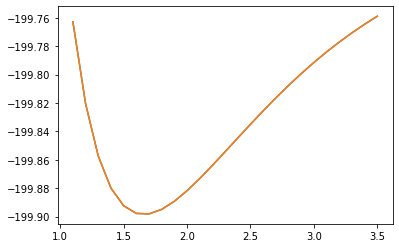

In [ ]:
from matplotlib import pyplot as plt


plt.plot(HF_bond, HF_spline)
plt.plot(HF_bond, chk)
plt.show()

In [68]:
# ==> Can set up loops here to iterate over bond lengths, 
#     compute rhf and cqed_rhf energies, store to arrays, 
#     and plot energy vs bond-length.
#     could also try this for different values of lam -> Ex, Ey, Ez
#mol = psi4.geometry("""
#0 1
#O
#H 1 1.1
#H 1 1.1 2 104
#symmetry c1
#""")
mol = psi4.geometry("""
            Mg
            H 1 1.7
            symmetry c1
            1 1
            """)



def RHF_lengths(lam):

    ### Testing new code, looping over various bond lengths and storing as a spline
    n_states = 2

    # set the number of bond lengths to compute the stretch along
    n_geoms = 25

    # initialize geometry list
    geoms = []

    # initialize energy list... note
    # there will be the ground state energy + n_states excited state energies
    Es = np.zeros((n_states+1, n_geoms))

    # initialize z-component of transition dipole list
    #mu_z = np.zeros((n_states, n_geoms))

    # generate bond lengths
    rs = []
    for i in range(0,n_geoms):
        rs.append(1.1 + i*0.1)
    

    ctr = 0
    for i in rs:
        # generate the MgH+ molecule using a z-matrix and set the Mg-H+ bond length
        mol = psi4.geometry("""
        Mg
        H 1 """ + str(i) + """
        symmetry c1
        1 1
        """)

        geoms.append(mol.geometry().to_array())
        psi4.set_options({
        'save_jk': True,
        })  

        rhf_e, cqed_rhf_e, wfn, CQED_C, CQED_D  = RHF(lam, mol)
        ### Returns ordinary HF energy, QED RHF energy, wfn object, C matrix, D matrix

        Es[0,ctr] = cqed_rhf_e
        
        # store the results to the respective arrays
        for j in range(0, n_states):
            Es[j+1,ctr] = cqed_rhf_e
        
        ctr += 1
    Eg_spline = InterpolatedUnivariateSpline(rs, Es[0,:], k=3)
    return rs, Eg_spline(rs)

QED_bond, QED_spline = RHF_lengths(lam)

rhf_e, cqed_rhf_e, wfn, CQED_C, CQED_D  = RHF(lam, mol)

#print(rhf_e, cqed_rhf_e)


Original RHF: -199.89812942048323 Hartrees CQED RHF: -199.90000626407806 Hartrees


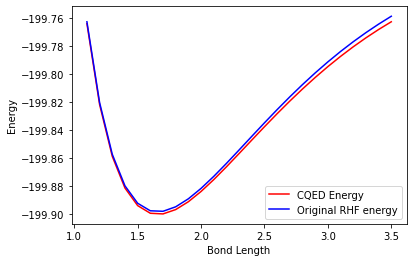

In [69]:
### So far only plots ground state energies.
print("Original RHF: {} Hartrees".format(rhf_e), "CQED RHF: {} Hartrees".format(cqed_rhf_e))
plt.plot(QED_bond, QED_spline, 'red', label='CQED Energy')
plt.plot(HF_bond, HF_spline, 'blue', label='Original RHF energy')
plt.xlabel('Bond Length')
plt.ylabel('Energy')
plt.legend()
plt.show()



### If this doesn't seem accurate, change the Es[0,ctr] and [Esj+1,ctr] both back to rhf_e

In [70]:
#### Comparing energy difference based on different lambda values
import pandas as pd
def compare_lam():
    print("Impacts of differing lambda array values for MgH+ at a fixed bond length of 1.7 Angstroms.")
    mol = get_molecule("MgH+")


    #lam = np.array([Ex, Ey, Ez])
    #E.g Ex = 1e-1, Ey = 1e-1, Ez = 1e-1, as was used earlier. 
    lam_dict = {'x':np.array([0.005,0,0]),'y':np.array([0,0.005,0]),'z':np.array([0,0,0.005]), 'xy':np.array([np.sqrt(.0025),np.sqrt(.0025),0]),'xz':np.array([np.sqrt(.0025),0,np.sqrt(.0025)]),'yz':np.array([0,np.sqrt(.0025),np.sqrt(.0025)])}
    Dif = []
    HFl = []
    RHFl = []
    for i, j in lam_dict.items():
        lam = j
        HF, RHF_E, wfn, C, D = RHF(lam, mol)
        Dif.append(abs(RHF_E-HF))
        HFl.append(HF) 
        RHFl.append(RHF_E)
        #print("{} favored.\nLambda Array = {}\n{}\nHF Energy: {} Hartrees.\nRHF Energy: {} Hartrees.\nDifference: {} Hartrees.\n".format(i,j, '~'*30, HF, RHF_E, Dif))
    
    return HFl, RHFl, Dif
HFl, RHFl, Dif = compare_lam()
plane = [np.array([0.005,0,0]),np.array([0,0.005,0]), np.array([0,0,0.005]), np.array([np.sqrt(.0025),np.sqrt(.0025),0]), np.array([np.sqrt(.0025),0,np.sqrt(.0025)]), np.array([0,np.sqrt(.0025),np.sqrt(.0025)])]
data =zip(HFl, RHFl, Dif)
df = pd.DataFrame(Dif)
df.columns = ['Difference']
#df['CQED'] = Dif
#df['Difference'] = Dif
i = ['x', 'y', 'z', 'xy', 'xz', 'yz']
#df['plane'] = plane
df.index = i
#df['RHF'] = RHFl
#df.columns = ['HF', 'RHF', 'Dif']
df['plane'] = plane
df

Impacts of differing lambda array values for MgH+ at a fixed bond length of 1.7 Angstroms.


,Difference,plane
x,0.000068,"[0.005, 0.0, 0.0]"
y,0.000068,"[0.0, 0.005, 0.0]"
z,0.000332,"[0.0, 0.0, 0.005]"
xy,0.013789,"[0.05, 0.05, 0.0]"
xz,0.041768,"[0.05, 0.0, 0.05]"
yz,0.041768,"[0.0, 0.05, 0.05]"


In [22]:
# RHF Wavefunction dict from the original RHF wavefunction object 'wfn'
scf_e, SCF_E, wfn, C, D = RHF(lam,mol)
rhf_wfn_dict = psi4.core.Wavefunction.to_file(wfn)
print("printing the wfn dictionary")
#print(rhf_wfn_dict['matrix']['Da'])

# Uncomment if you want to compare the original RHF orbitals to the 
# CQED-RHF orbitals that are stored in the numpy array 'C'?
#print(np.isclose(rhf_wfn_dict['matrix']['Ca'], C))
#print(np.isclose(rhf_wfn_dict['matrix']['Cb'], C))


# Get orbital perturbation from CQED

rhf_wfn_dict['matrix']['Ca'] -= CQED_C
rhf_wfn_dict['matrix']['Cb'] -= CQED_C

# Get density perturbation from CQED
rhf_wfn_dict['matrix']['Da'] = CQED_D
rhf_wfn_dict['matrix']['Db'] = CQED_D

'''
rhf_wfn_dict['matrix']['Ca'] -= C
rhf_wfn_dict['matrix']['Cb'] -= C

rhf_wfn_dict['matrix']['Da'] = D
rhf_wfn_dict['matrix']['Db'] = D
'''
print("density")
#print(rhf_wfn_dict['matrix']['Da'])
# Now create a new wavefunction object that has the CQED-RHF orbitals 'cqedrhf_wfn'
cqedrhf_wfn = psi4.core.Wavefunction.from_file(rhf_wfn_dict) 

# Confirm you have copied the CQED-RHF orbitals properly 
# by again getting a dic of the wavefunction and comparing
# the orbitals to the original numpy array 'C' that resulted
# from the CQED-RHF iterations
cqedrhf_wfn_dict = psi4.core.Wavefunction.to_file(cqedrhf_wfn)
#print(cqedrhf_wfn_dict['matrix']['Ca'])
#print(cqedrhf_wfn_dict['matrix']['Cb'])
#assert np.allclose(cqedrhf_wfn_dict['matrix']['Ca'], C, 1e-6)
#assert np.allclose(cqedrhf_wfn_dict['matrix']['Cb'], C, 1e-6)


printing the wfn dictionary
density


In [23]:

from matplotlib import pyplot as plt
from helper_cqed_rhf import *

def C_RHF_lengths(lam):
    
    ### Testing new code, looping over various bond lengths and storing as a spline
    n_states = 2

    # set the number of bond lengths to compute the stretch along
    n_geoms = 25

    # initialize geometry list
    geoms = []

    # initialize energy list... note
    # there will be the ground state energy + n_states excited state energies
    Es = np.zeros((n_states+1, n_geoms))

    # initialize z-component of transition dipole list
    #mu_z = np.zeros((n_states, n_geoms))

    # generate bond lengths
    rs = []
    for i in range(0,n_geoms):
        rs.append(1.1 + i*0.1)
    

    ctr = 0
    for i in rs:
        # generate the MgH+ molecule using a z-matrix and set the Mg-H+ bond length
        mol = psi4.geometry("""
        Mg
        H 1 """ + str(i) + """
        symmetry c1
        1 1
        """)

        geoms.append(mol.geometry().to_array())
        psi4.set_options({
        'save_jk': True,
        })  

        rhf_e, cqed_rhf_e, wfn, CQED_C, CQED_D  = cqed_rhf(lam, mol, self_consistent_dipole=True)
        ### Returns ordinary HF energy, QED RHF energy, wfn object, C matrix, D matrix

        Es[0,ctr] = rhf_e
        
        # store the results to the respective arrays
        for j in range(0, n_states):
            Es[j+1,ctr] = cqed_rhf_e
        
        ctr += 1
    Eg_spline = InterpolatedUnivariateSpline(rs, Es[0,:], k=3)
    return rs, Eg_spline(rs)

New_QED_bond, New_QED_spline = C_RHF_lengths(lam)


plt.plot(New_QED_bond, New_QED_spline, 'red')
plt.plot(HF_bond, HF_spline, 'blue')
plt.show()

AttributeError: 'psi4.core.Molecule' object has no attribute 'strip'

In [9]:
psi4.set_options({
    'CUBEPROP_TASKS': ['ORBITALS', 'DENSITY'],
    'CUBEPROP_ORBITALS': [1,2,3,4,5,6,7,8,9,10],
})
psi4.cubeprop(cqedrhf_wfn)

In [1]:
import fortecubeviewer
fortecubeview.plot()

ModuleNotFoundError: No module named 'fortecubeviewer'

In [10]:
import forte.utils


ModuleNotFoundError: No module named 'torch'